In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


# 1️⃣Importing essential libraries


In [3]:
# Prevent read-only database error
import os
os.environ["IPYTHONDIR"] = "/tmp"

In [4]:
# Now import your libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [5]:
# Setting a clean theme for visuals
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# 2️⃣ Load Dataset (Auto-detect file)

In [6]:
base_path = "/kaggle/input/online-retail-ii-uci"
files = os.listdir(base_path)
print("Available files:", files)

for file in files:
    if file.endswith(".xlsx"):
        data = pd.read_excel(os.path.join(base_path, file), sheet_name="Year 2009-2010")
    elif file.endswith(".csv"):
        data = pd.read_csv(os.path.join(base_path, file))

print("✅ Dataset Loaded Successfully!")
print(f"Shape: {data.shape}")
data.head(3)


Available files: ['online_retail_II.csv']
✅ Dataset Loaded Successfully!
Shape: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


# 3️⃣ Basic dataset overview

In [7]:
data.info()
display(data.describe())
display(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

# 🧩 Observation:

- The dataset contains transactional data of an online retail store from 2009–2010.
- There are missing values in the **Customer ID** column, indicating guest or incomplete transactions.
- Some transactions have **negative quantities**, representing product returns or cancellations.


# 4️⃣ Data Cleaning

In [8]:
# Drop rows with missing Customer IDs
data = data.dropna(subset=["Customer ID"])

In [9]:
# Remove canceled or invalid transactions
data = data[(data["Quantity"] > 0) & (data["Price"] > 0)]


In [10]:
# Convert data types
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["Customer ID"] = data["Customer ID"].astype(int)

In [11]:
# Create TotalSales column
data["TotalSales"] = data["Quantity"] * data["Price"]

print("✅ Data cleaned successfully!")
data.head(3)

✅ Data cleaned successfully!


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0


# 5️⃣ Univariate Analysis

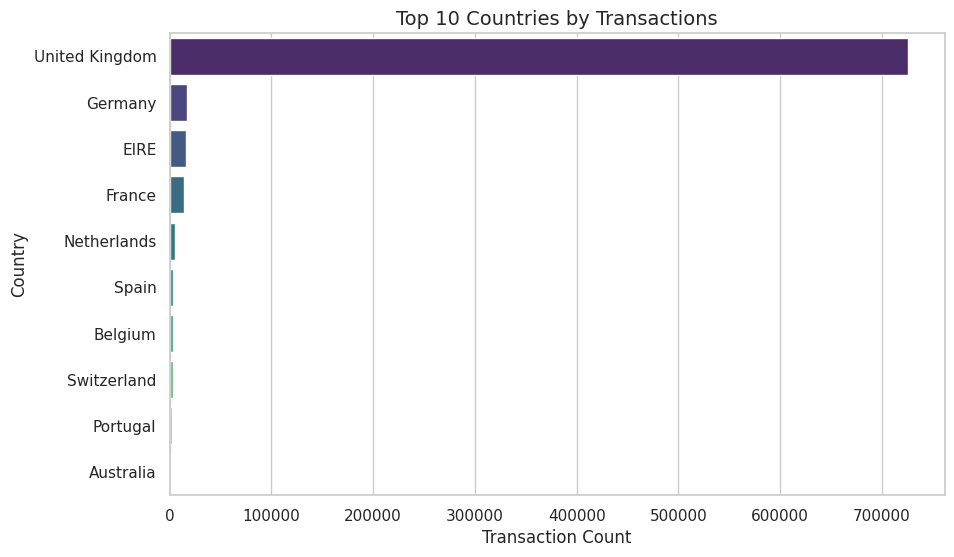

In [12]:
# Top 10 Countries by Transactions
top_countries = data["Country"].value_counts().head(10)
sns.barplot(y=top_countries.index, x=top_countries.values, palette="viridis")
plt.title("Top 10 Countries by Transactions")
plt.xlabel("Transaction Count")
plt.ylabel("Country")
plt.show()

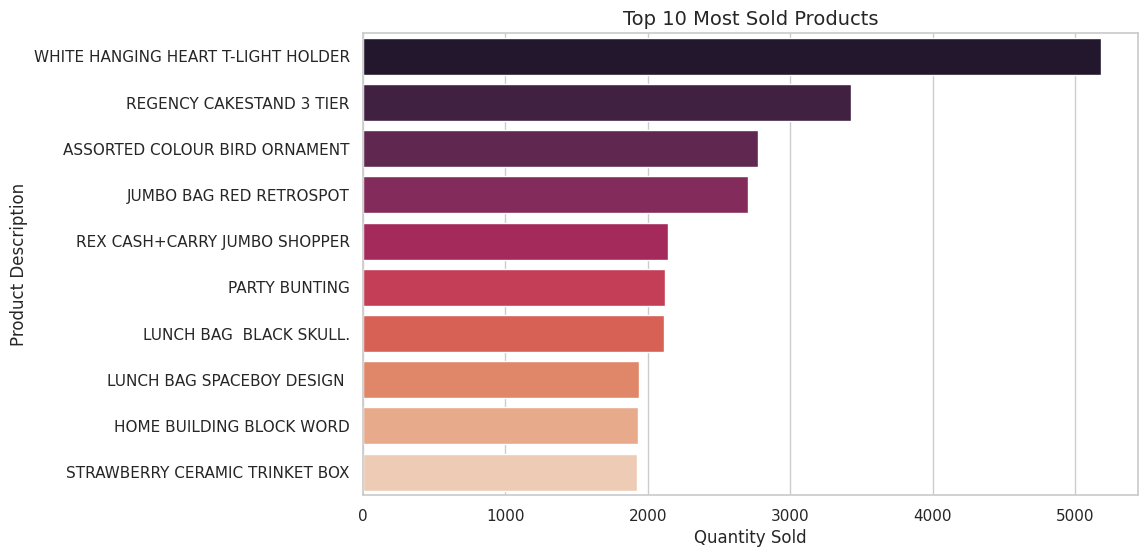

In [13]:
# Top 10 Most Sold Products
top_products = data["Description"].value_counts().head(10)
sns.barplot(y=top_products.index, x=top_products.values, palette="rocket")
plt.title("Top 10 Most Sold Products")
plt.xlabel("Quantity Sold")
plt.ylabel("Product Description")
plt.show()

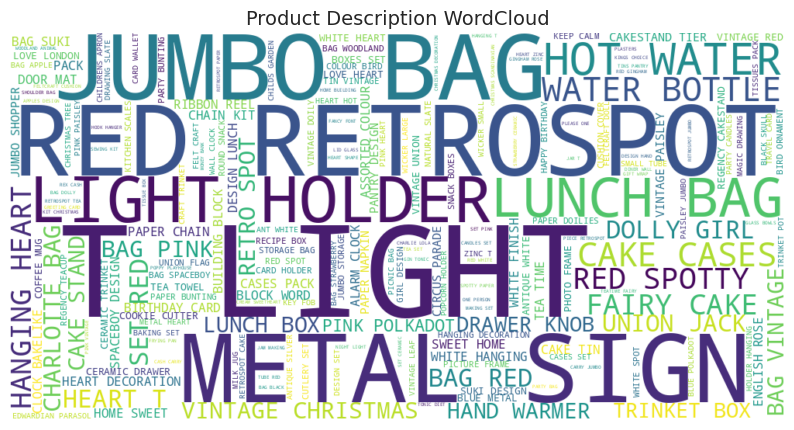

In [14]:
# WordCloud of Product Descriptions
text = " ".join(data["Description"].astype(str))
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Product Description WordCloud")
plt.show()

****Here we analyze the top countries, best-selling products, and visualize trends using barplots and word clouds.****


# 6️⃣ Bivariate Analysis

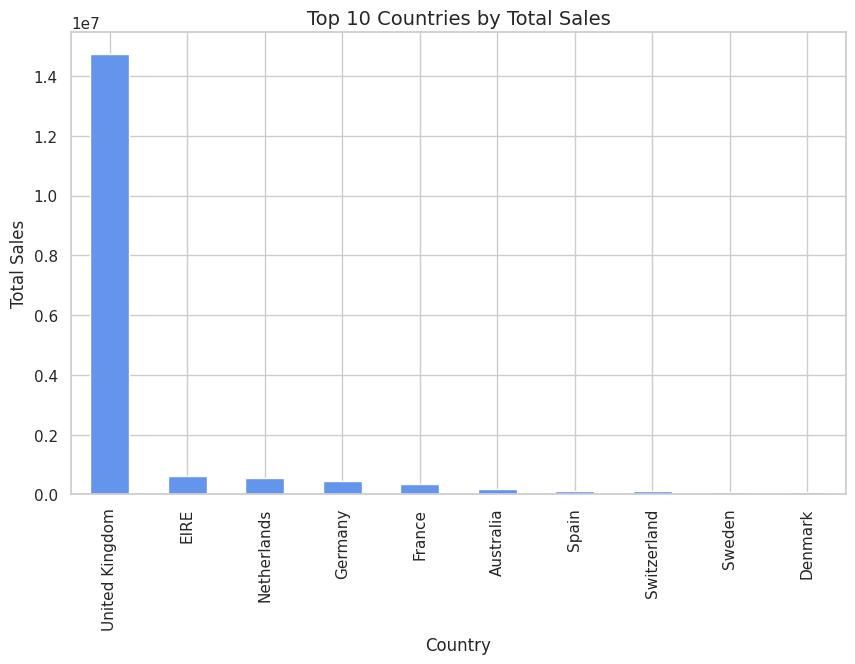

In [15]:
# Top 10 Countries by Sales
country_sales = data.groupby("Country")["TotalSales"].sum().sort_values(ascending=False).head(10)
country_sales.plot(kind="bar", color="cornflowerblue")
plt.title("Top 10 Countries by Total Sales")
plt.ylabel("Total Sales")
plt.show()


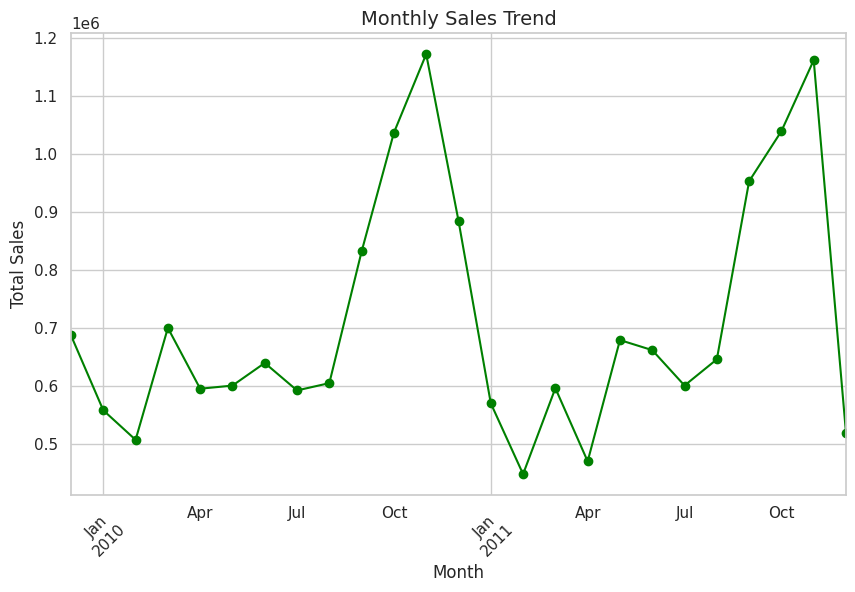

In [16]:
# Monthly Sales Trend
data["Month"] = data["InvoiceDate"].dt.to_period("M")
monthly_sales = data.groupby("Month")["TotalSales"].sum()
monthly_sales.plot(marker="o", color="green")
plt.title("Monthly Sales Trend")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

# 7️⃣ Time-Based Insights

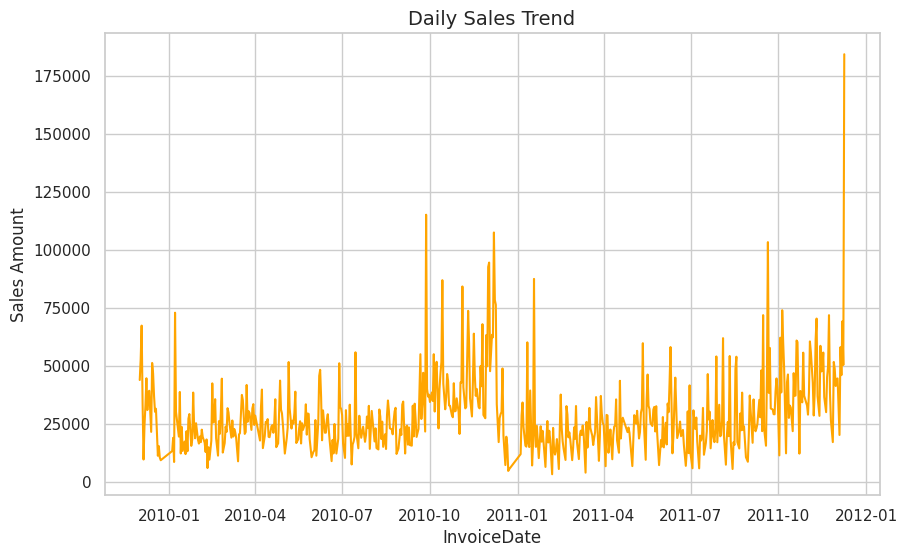

In [17]:
# Daily sales trend
daily_sales = data.groupby(data["InvoiceDate"].dt.date)["TotalSales"].sum()
daily_sales.plot(color="orange")
plt.title("Daily Sales Trend")
plt.ylabel("Sales Amount")
plt.show()

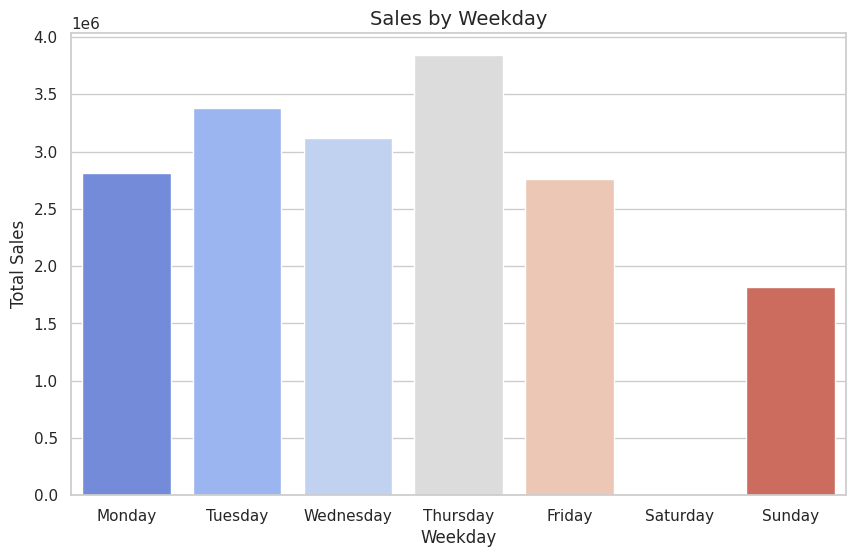

In [18]:
# Sales by Weekday
data["Weekday"] = data["InvoiceDate"].dt.day_name()
weekday_sales = data.groupby("Weekday")["TotalSales"].sum().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette="coolwarm")
plt.title("Sales by Weekday")
plt.ylabel("Total Sales")
plt.show()

# 8️⃣ RFM (Recency, Frequency, Monetary) Analysis

In [19]:
snapshot_date = data["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = data.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "Invoice": "nunique",
    "TotalSales": "sum"
})
rfm.rename(columns={"InvoiceDate": "Recency", "Invoice": "Frequency", "TotalSales": "Monetary"}, inplace=True)


In [20]:
# Scoring
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].astype(int).sum(axis=1)

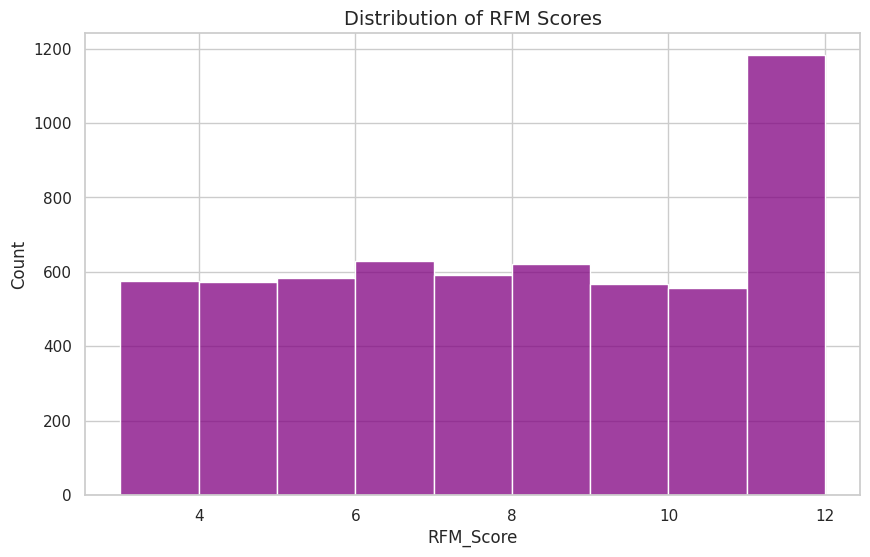

In [21]:
sns.histplot(rfm["RFM_Score"], bins=9, color="purple")
plt.title("Distribution of RFM Scores")
plt.show()


In [22]:
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
12346,326,12,77556.46,2,4,4,10
12347,2,8,5633.32,4,4,4,12
12348,75,5,2019.40,3,3,3,9
12349,19,4,4428.69,4,3,4,11
12350,310,1,334.40,2,1,1,4


# 🔹 **Key Insights**

### 📌 Observations:
- 🇬🇧 **UK contributes ~85% of sales.**
- 📅 **November–December shows seasonal spikes (holiday sales).**
- 🎁 **Gift items and decorative products dominate the top-selling list.**
- 💳 **RFM segmentation identifies loyal vs. at-risk customers.**

---

### 💡 Business Recommendations:
- 🎯 **Target high RFM-score customers** with loyalty discounts or personalized offers.  
- 📈 **Launch campaigns during peak months (Nov–Dec)** to maximize conversions.  
- 🏷️ **Focus restocking and marketing on top-selling categories** to improve inventory efficiency.  


# 🔟 Export cleaned and RFM datasets

In [23]:
data.to_csv("cleaned_online_retail.csv", index=False)
rfm.to_csv("rfm_analysis.csv", index=False)

print("✅ Exported cleaned and RFM data successfully!")

✅ Exported cleaned and RFM data successfully!


### 📘 Conclusion:
This EDA provided actionable insights into **sales trends, customer behavior, and product performance**.  
The analysis serves as a strong foundation for **future predictive modeling** — such as customer segmentation, sales forecasting, or churn prediction.